In [1]:
from src.model import PyTradeShifts
from src.postprocessing import Postprocessing
import pandas as pd
import os
os.chdir('../../')
print(os.getcwd())

/home/florian/Documents/GitHub/pytradeshifts


First let's compare the overall structure of the data. How many countries are affected in the scenario and by how much?

In [2]:
LoI_data = pd.read_csv("data/scenario_files/losing_industry/Wheat2mean_values.csv")
print("The average yield reduction globally for global catastrophic infrastructure is: ", LoI_data["mean_value"].mean())
print("This considers n = ", len(LoI_data), " countries")

The average yield reduction globally for global catastrophic infrastructure is:  -34.79496316270323
This considers n =  94  countries


In [3]:
NW_data = pd.read_csv("data/scenario_files/nuclear_winter/xia_47tg_y3_swheat.csv")
print("The average yield reduction globally for nuclear winter is: ", NW_data["47tg"].mean())
print("This considers n = ", len(NW_data), " countries")

The average yield reduction globally for nuclear winter is:  -35.93313559322034
This considers n =  118  countries


Next we calculate the trade communities for our base scenario as well as global catastrophic infrastructure loss and abrupt sunlight reduction.

In [4]:
base_year = 2022
Wheat_base = PyTradeShifts(
    "Wheat",
    base_year=base_year,
    region="Global",
    testing=False,
    cd_kwargs={"seed": 2},
    make_plot=False,
)
loss_of_industry = PyTradeShifts(
    crop="Wheat",
    base_year=base_year,
    scenario_file_name="losing_industry/Wheat2mean_values.csv",
    scenario_name="Global Catastrophic Infrastructure Loss",
    cd_kwargs={"seed": 2},
    make_plot=False,
)
asrs = PyTradeShifts(
    crop="Wheat",
    base_year=base_year,
    scenario_file_name="nuclear_winter/xia_47tg_y3_swheat.csv",
    scenario_name="Abrupt Sunlight Reduction Scenario",
    cd_kwargs={"seed": 2},
    make_plot=False,
)

Loaded data for Wheat in Y2022.
Removed 1 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.
Removed countries with trade below the 75th percentile.
Built trade graph.
Found 6 trade communities.
Loaded data for Wheat in Y2022.
Removed 1 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.
Removed countries with trade below the 75th percentile.


Applied scenario Global Catastrophic Infrastructure Loss.
Built trade graph.
Found 6 trade communities.
Loaded data for Wheat in Y2022.
Removed 1 countries with no trade or production.
Prebalanced trade matrix.
Corrected re-exports.
Removed countries with trade below the 75th percentile.
Applied scenario Abrupt Sunlight Reduction Scenario.
Built trade graph.
Found 6 trade communities.


To compare the scenario to each other, we have to do a bunch of additional calculations. These all happen in the postprocessing class. Anchor countries are user-specified list of countries that the script attempts to keep the same colour between scenarios.

In [5]:
comparison = Postprocessing([Wheat_base, loss_of_industry, asrs], anchor_countries=["Brazil", "United States", "Russia", "Uzbekistan" "Germany"])

Starting postprocessing computations...


Next lets look at how the trade communities change globally in the different scenarios. 

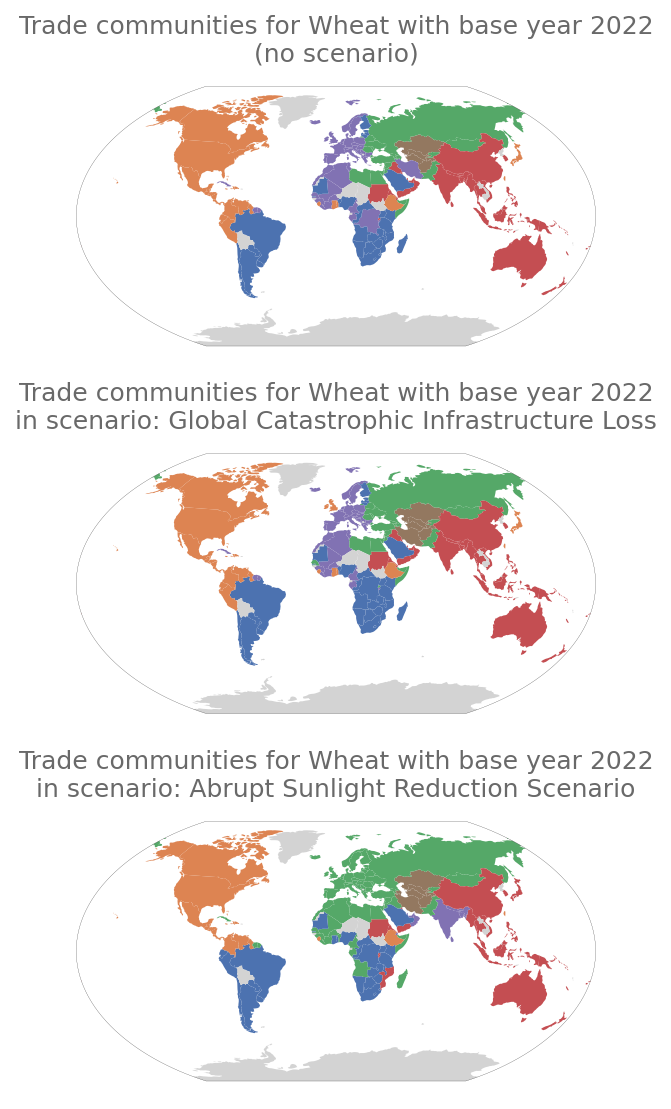

In [6]:
comparison.plot_all_trade_communities()

We can also try to quantify how different the communities are in each scenario for each country.
The natural way of doing this is the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
It measures the similarity between two sets.
So for each country we can compute a Jaccard distance (1-Jaccard index)
showing us by how much for each country their community changed in comparison with the base scenario.

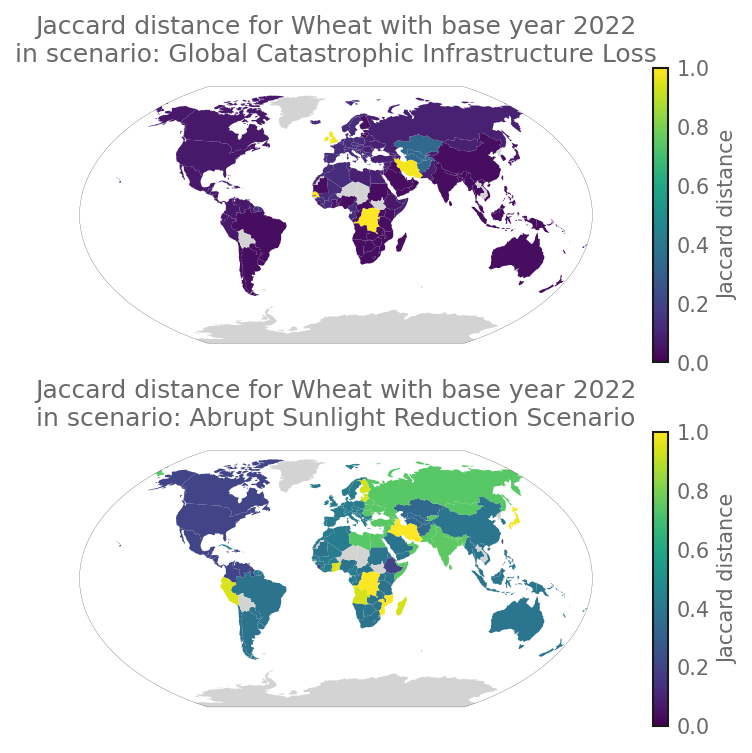

In [7]:
comparison.plot_community_difference(vmin=0, vmax=1)

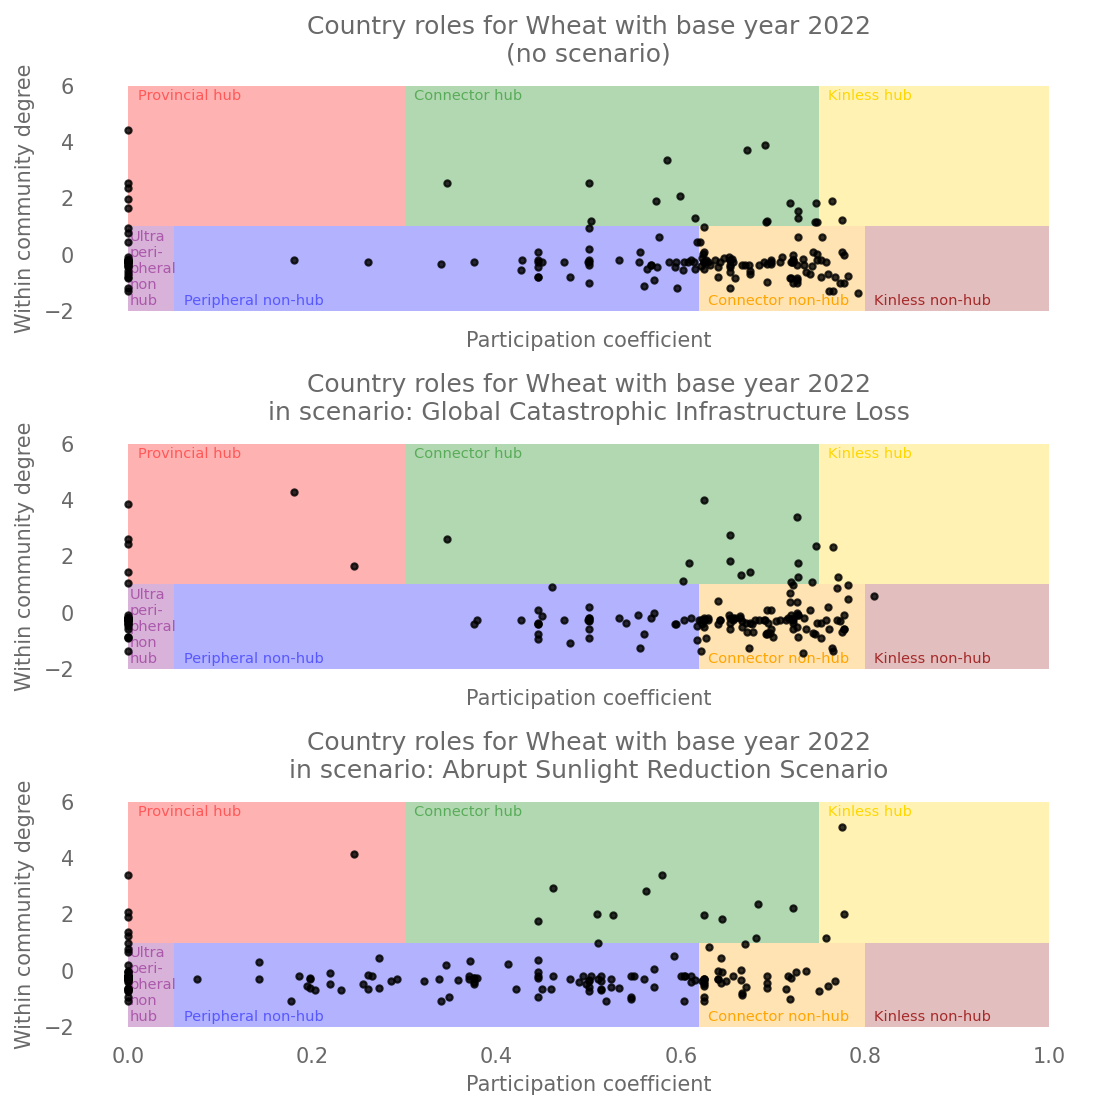

In [8]:
comparison.plot_roles()

We can also study the degree centralities (in and out) for all networks:

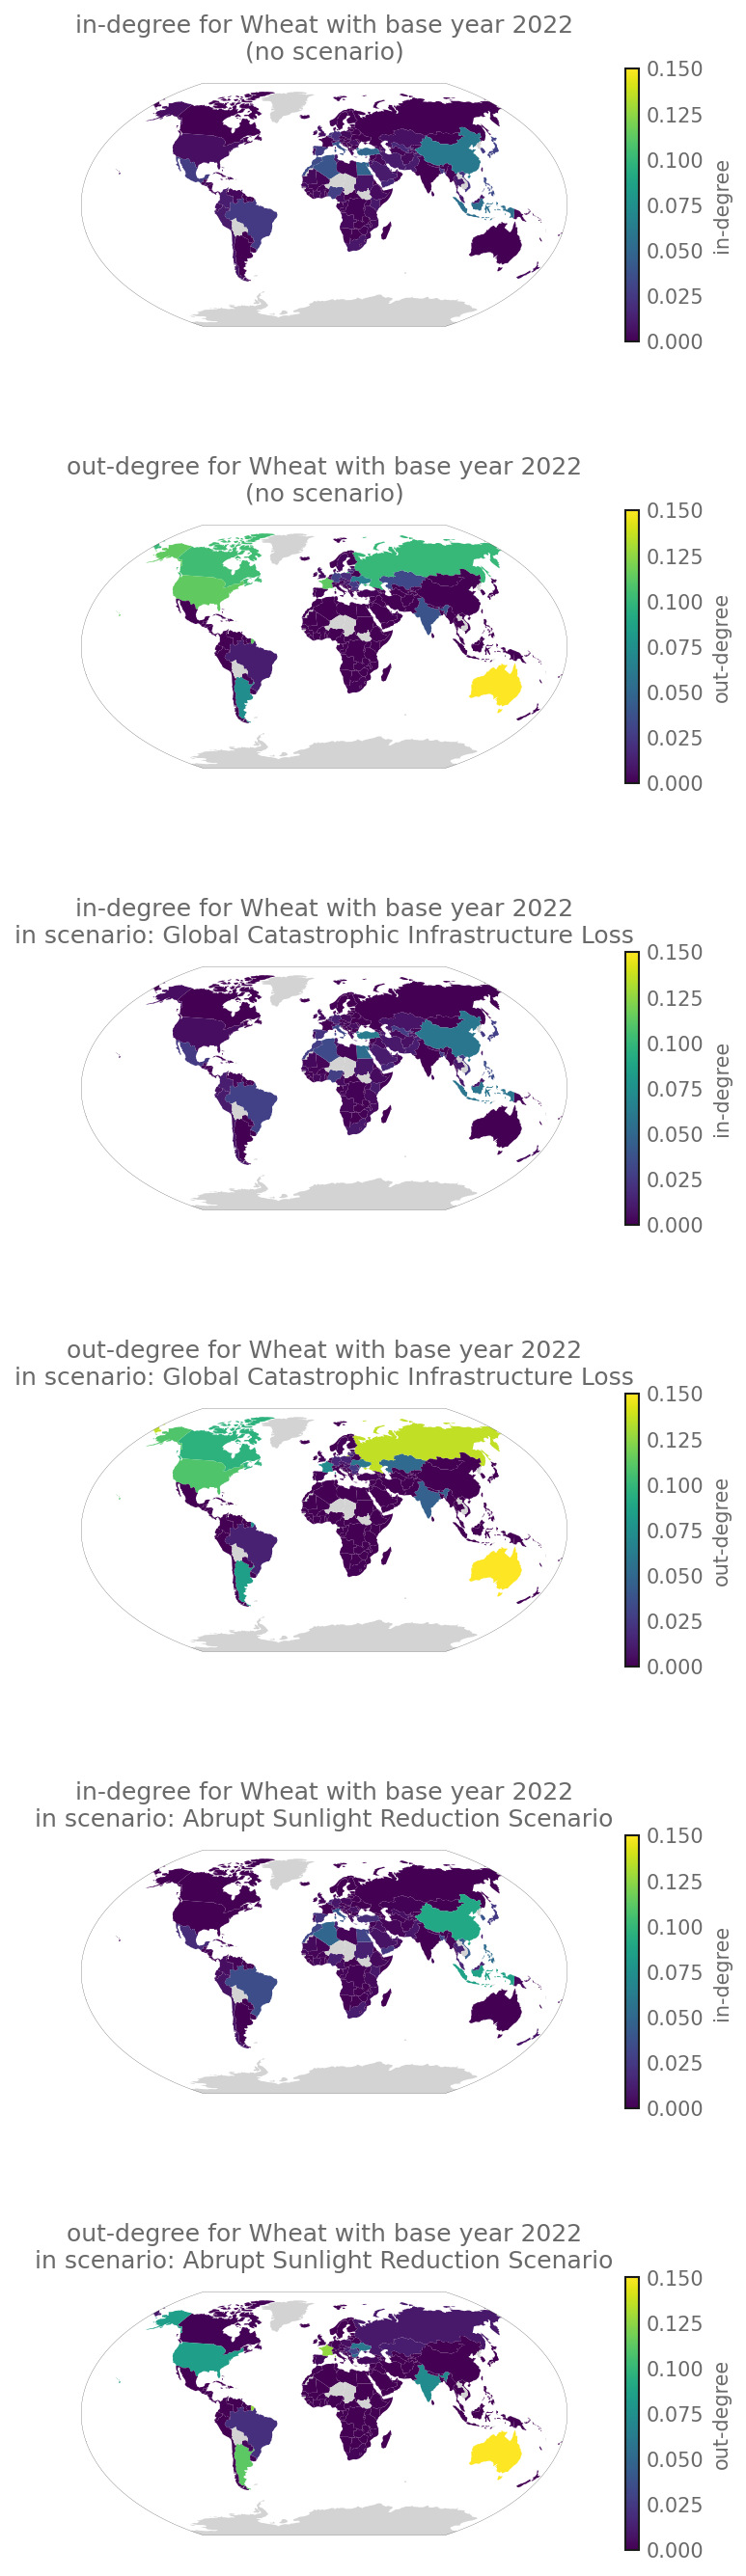

In [9]:
comparison.plot_centrality_maps(figsize=(5, 25), shrink=0.2, vmin=0, vmax=0.15)

and in tabulated form, global:

In [10]:
comparison.print_global_centrality_metrics(index=False)

***| Degree centrality metrics for each scenario |***
╒═════════════╤═════════════╤═════════════╤═════════════╤══════════════╤══════════════╤══════════════╤══════════════╕
│ Smallest    │    Smallest │ Largest     │     Largest │ Smallest     │     Smallest │ Largest      │      Largest │
│ in-degree   │   in-degree │ in-degree   │   in-degree │ out-degree   │   out-degree │ out-degree   │   out-degree │
│ country     │       value │ country     │       value │ country      │        value │ country      │        value │
╞═════════════╪═════════════╪═════════════╪═════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ Argentina   │           0 │ China       │   0.0607331 │ Afghanistan  │            0 │ Australia    │     0.162048 │
├─────────────┼─────────────┼─────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ Argentina   │           0 │ Türkiye     │   0.0618672 │ Afghanistan  │            0 │ Australia    │     0.173626 │
├─

and for each community in each scenario. Note: the community ID doesn't mean much, it is just the index in the list scenario.trade_communities

In [11]:
comparison.print_per_community_centrality_metrics(index=False)

***| Degree centrality metrics for the scenario with ID: 0 |***
╒══════════════╤═════════════╤═════════════╤═════════════╤══════════════╤══════════════╤═══════════════╤══════════════╕
│ Smallest     │    Smallest │ Largest     │     Largest │ Smallest     │     Smallest │ Largest       │      Largest │
│ in-degree    │   in-degree │ in-degree   │   in-degree │ out-degree   │   out-degree │ out-degree    │   out-degree │
│ country      │       value │ country     │       value │ country      │        value │ country       │        value │
╞══════════════╪═════════════╪═════════════╪═════════════╪══════════════╪══════════════╪═══════════════╪══════════════╡
│ Argentina    │ 0           │ Nigeria     │   0.0276539 │ Angola       │            0 │ Argentina     │    0.0728485 │
├──────────────┼─────────────┼─────────────┼─────────────┼──────────────┼──────────────┼───────────────┼──────────────┤
│ Sierra Leone │ 2.83109e-06 │ Japan       │   0.0294449 │ Bahamas      │            0 │ United 

We can plot a community satisfaction index, taken from [here](https://www.mdpi.com/2304-8158/12/2/271).

It measures how much of each country's import is satisfied by their community.

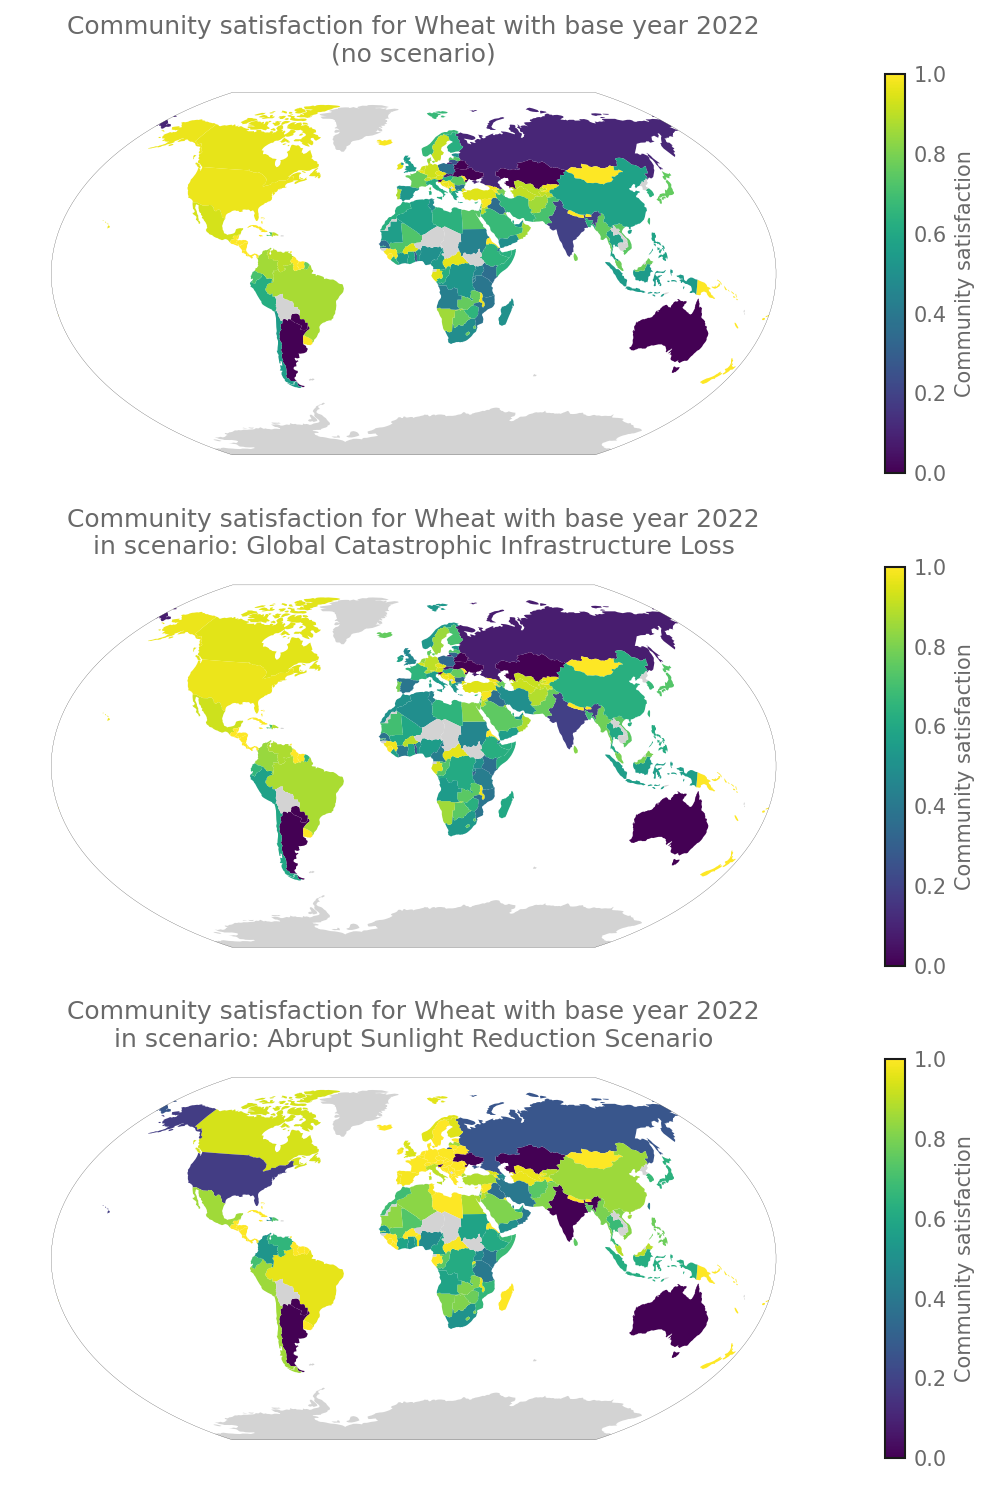

In [12]:
comparison.plot_community_satisfaction(figsize=(10, 10))

and the difference from base scenario:

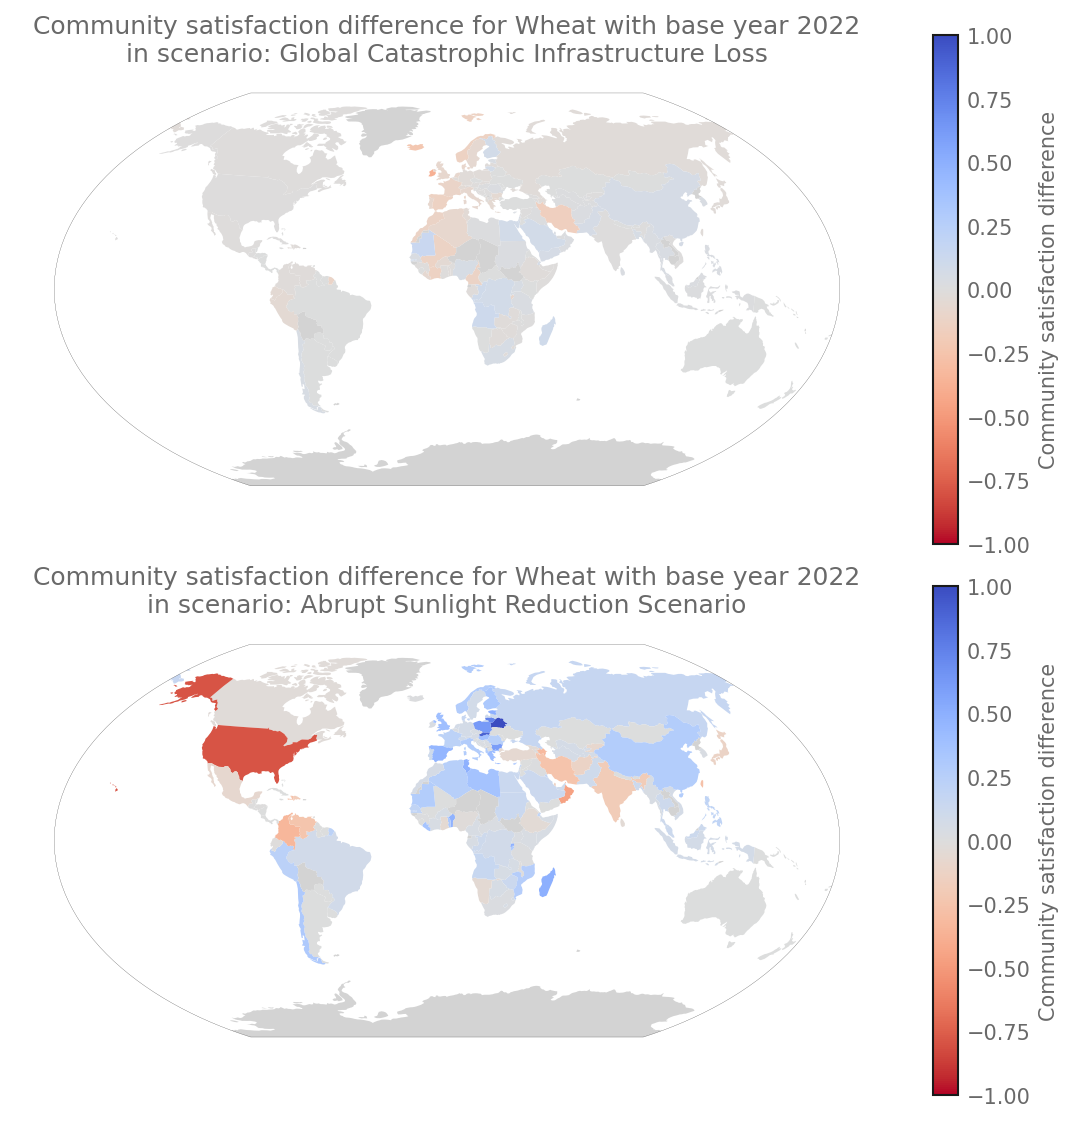

In [18]:
comparison.plot_community_satisfaction_difference(figsize=(7.5, 7.5), vmin=-1, vmax=1, cmap="coolwarm_r")

We also can look at country's stability index, which is a measure of how easily each country can replace their import partners (same paper as community satisfaction).

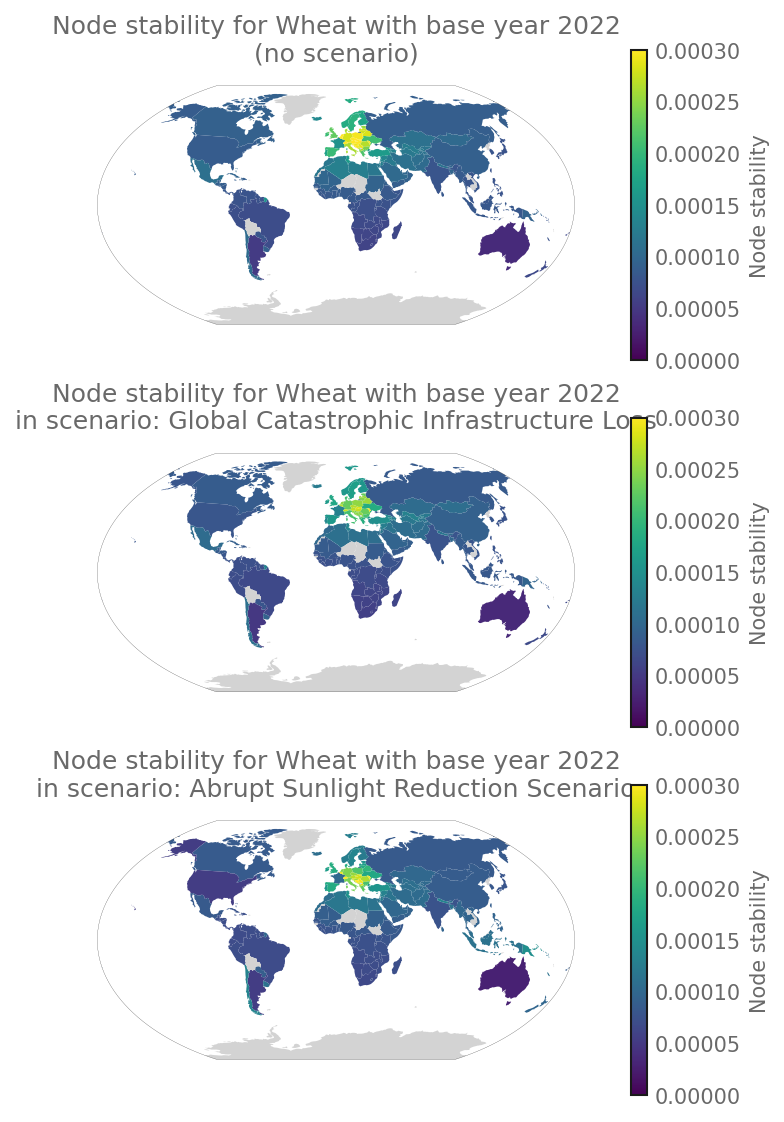

In [14]:
comparison.plot_node_stability(vmin=0, vmax=0.0003) # figsize works here too of course

The units are dimensionless, so it is better to look at the relative change of the node stability to get a better view. 
For this reason we can look at the *relative* change of this metric:

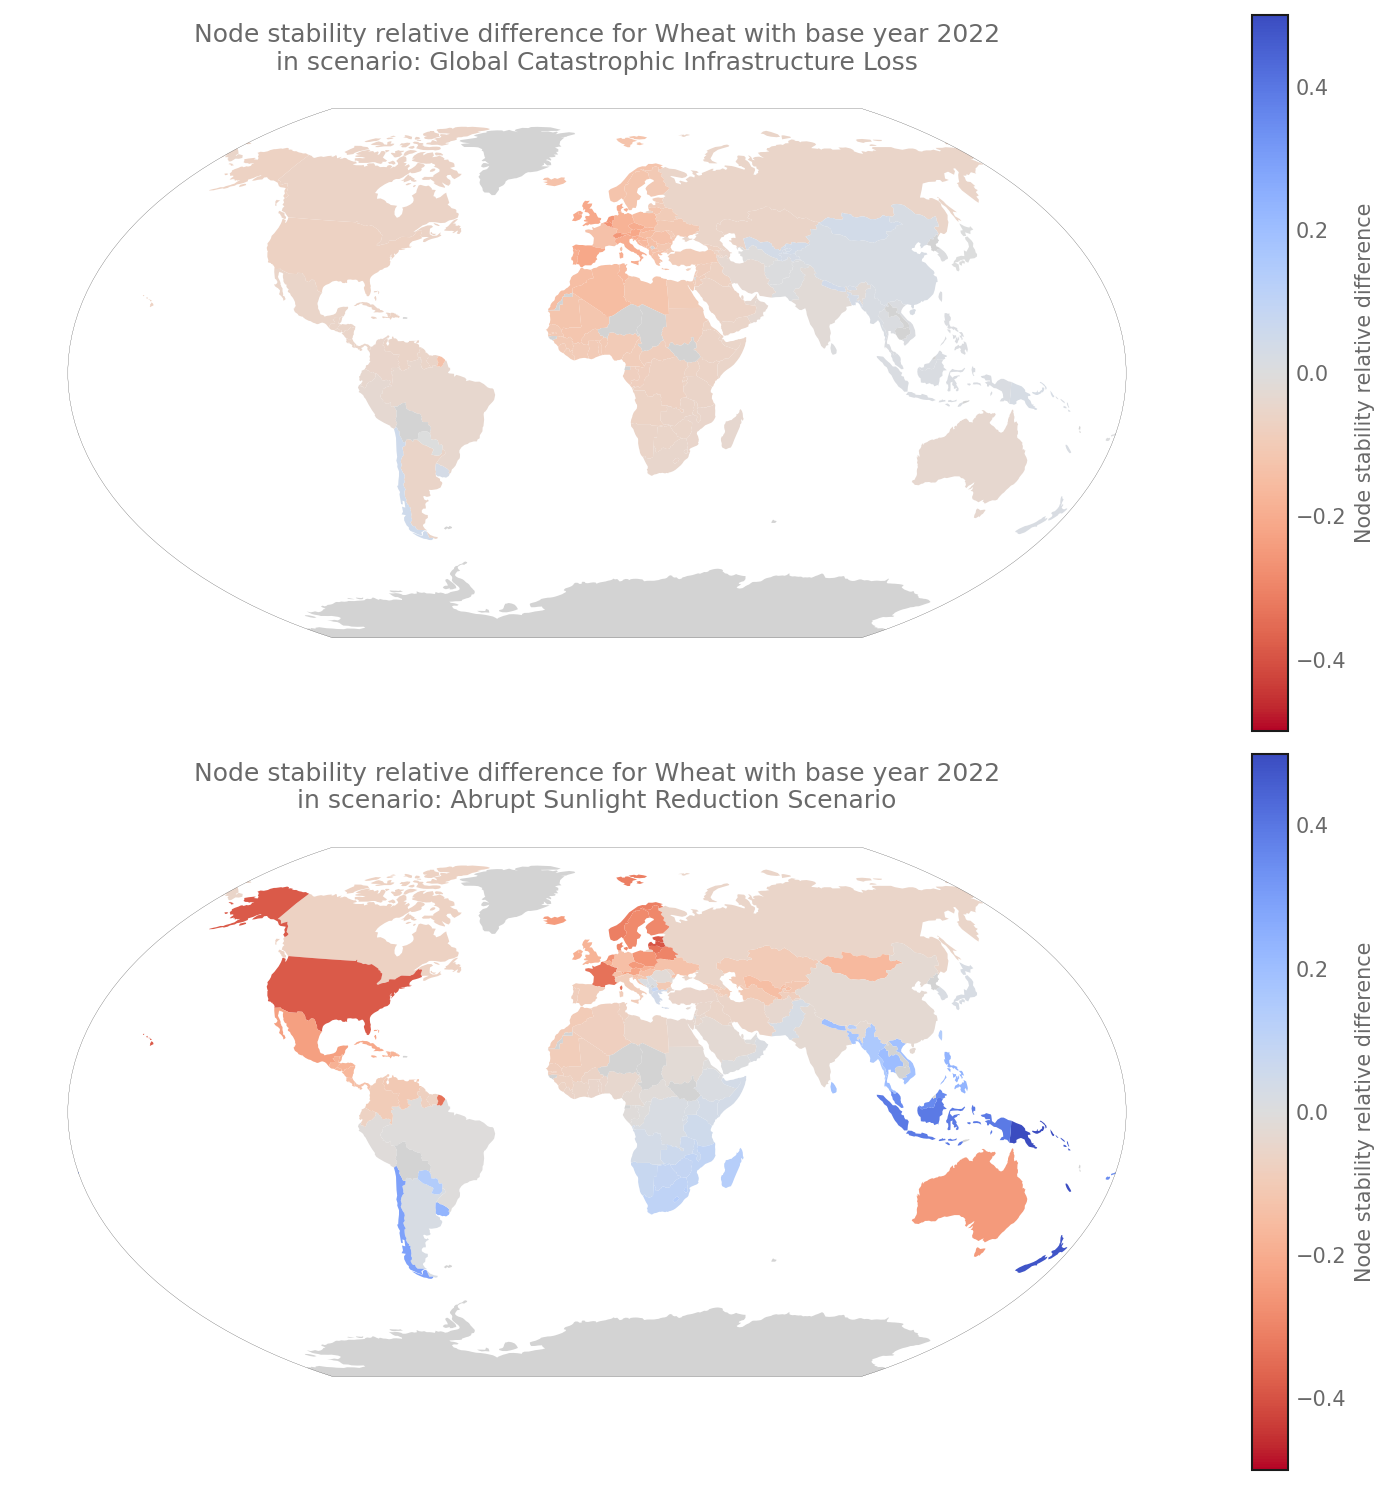

In [19]:
comparison.plot_node_stability_difference(figsize=(10, 10), vmin=-0.5, vmax=0.5, cmap="coolwarm_r")

Another important aspect of a network is its resilience to attacks, and we can see that as well:

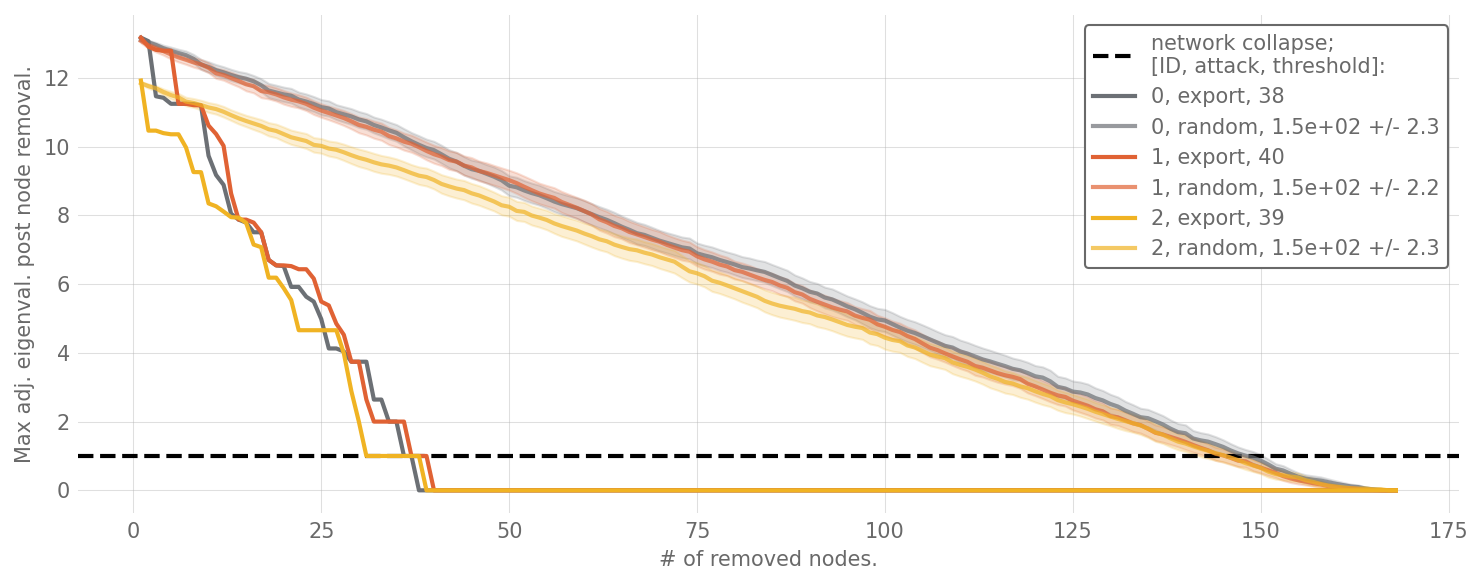

In [16]:
comparison.plot_attack_resilience(exclude_attacks="entropic")

This is based on [this paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.058701).

In there, the authors show that we can approximate the network percolation threshold with the largest eigenvalue of a particular matrix (details in paper/code docs).

We consider three modes of attack: export based, entropic degree based, and random.

Export based means that we remove nodes in order of their out-degree (relative exporting importance), highest to lowest.

Random means we remove the nodes at random. This also requires us to recompute this many times to get decent statistic (controlled by a parameter passed to postprocessing class). That's why the 'random' curves have error bands and a '+/-' next to their threshold value.
The error band and threshold error is controlled by a sigma parameter (passed directly to the function). By default we're computing a [2-sigma result](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule).

In the legedn: ID refers to the scenario ID as passed into the postprocessing class, next is the attack type and finally the threshold value. This threshold tells us how many nodes need to be removed to collapse the network.

In [17]:
comparison.print_network_metrics()

╒═══════════════╤═══════════════╤══════════════╤══════════════╤═══════════════════╤═════════════════╤═════════════════╤═════════════╕
│   Scenario ID │   Betweenness │   Clustering │   Efficiency │   Entropic-attack │   Export-attack │ Random-attack   │   Stability │
│               │               │              │              │         threshold │       threshold │ threshold       │             │
╞═══════════════╪═══════════════╪══════════════╪══════════════╪═══════════════════╪═════════════════╪═════════════════╪═════════════╡
│             0 │    0.00463187 │  0.00289272  │     0.129134 │                37 │              38 │ 1.5e+02 +/- 1.2 │ 0.000129036 │
├───────────────┼───────────────┼──────────────┼──────────────┼───────────────────┼─────────────────┼─────────────────┼─────────────┤
│             1 │    0.00477852 │  0.00239208  │     0.115993 │                38 │              40 │ 1.5e+02 +/- 1.1 │ 0.000111407 │
├───────────────┼───────────────┼──────────────┼──────────────